# Unit 2 - Introduction to Feedback and Control

# Outline
- The advantages/objectives of control
- The feedback equation (sensitivity and complementary sensitivity functions)
- Proportional controller
- Root Locus plots
- Loop shaping 

# Notation

![openloop](openloop.png "Open-Loop")

- $P$: plant (system)
- $u$: input (variable can be manipulated)
- $y$: output (variable to be controlled)
- $d$: disturbance (affects value of input)
- $n$: measurement noise (sensor noise) (affects the measurement of a variable)

![feedbackloop](feedbackloop.png "Feedback")

- $K$: controller
- $r$: reference signal (desired output)
- $y_m$: measured output
- $\varepsilon$ (difference between desired output and measured output)


# Why feedback?

- Ability to follow desired signals
- Stability (design)
- Reduction of effects of process noise / load disturbances (noise rejection, compensation)
- Reduction of effects of model uncertainties
- Efficiency (design)

# Let's illustrate these advantages using a simplified model a cruise control system!

![Car](car.png "Car")

source: https://www.istockphoto.com/photos/futuristic-car-isolated


![Car free body diagram](car-free-body-diagram.png "Car free body diagram")

where,
- $F_d$ is the force due to drag
- $F_f$ is the force due to friction
- $F_a$ is the force applied by the wheels

Force due to drag:
$$
\begin{align*}
F_d = k_d v 
\end{align*}
$$
where 
- $k_d$ is drag coefficient,
- $v$ is speed of the car. 

Force due to gravity:
$$
\begin{align*}
F_g = m g 
\end{align*}
$$
where 
- $m$ is mass of car,
- $g$ is acceleration due to gravity. 

Force due to friction:
$$
\begin{align*}
F_f &= k_f v F_n \\
&= k_f v F_g \\
&= k_f v m g \\
\end{align*}
$$
where 
- $F_n$ is normal force,
- $k_f$ is friction coefficient.

# In Class Activity!

Derive transfer function of the simplified car model where $F_a$ is the input and $v$ is the output.

# Putting it all together. 

Sum of forces:
$$
\begin{align*}
\sum F &= ma \\
F_a(t) - F_d(t) - F_f(t) &= ma(t) \\
F_a(t) - k_dv(t) - k_fmgv(t) &= m \frac{\text{d} v(t)}{\text{dt}} \\
F_a(t) - (k_d - k_fmg)v(t) &= m \frac{\text{d} v(t)}{\text{dt}}
\end{align*}
$$
let $k=k_d-k_fmg$, then:
$$
\begin{align*}
F_a(t) - k v(t)= m \frac{\text{d} v(t)}{\text{dt}}
\end{align*}
$$

Take Laplace transform of both sides:
$$
\begin{align*}
F_a(s) - k V(s) = m(sV(s)-v(0))
\end{align*}
$$
Rearrange:
$$
\begin{align*}
V(s) = \frac{1}{ms + k}F(s) - \frac{m}{ms + k}v(0)
\end{align*}
$$
So the transfer function of the car is:
$$
\begin{align*}
G(s) = \frac{1}{ms + k}
\end{align*}
$$





In [1]:
import control as ct
import numpy as np
import enel441_utilities as eu
import math
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
# Very simple model of a car (input = force applied by wheels, output = speed of car)
m = 1000 #kg
k = 500 #Ns/m

s = ct.tf('s')
Car = 1/(m*s+k)

# Controller (for cruise control) For this lecture, I have designed this controller. 
# In the remainder of this course, you will learn how to design this type of controller.
K = 1*(m*s+k)/s
  

# In Class Activity

Spend some time exploring this model. Make Bode plot, S-plane plot, Unit Step Response.

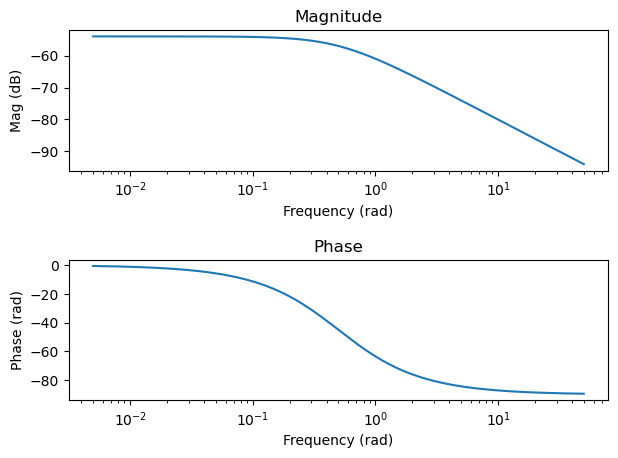

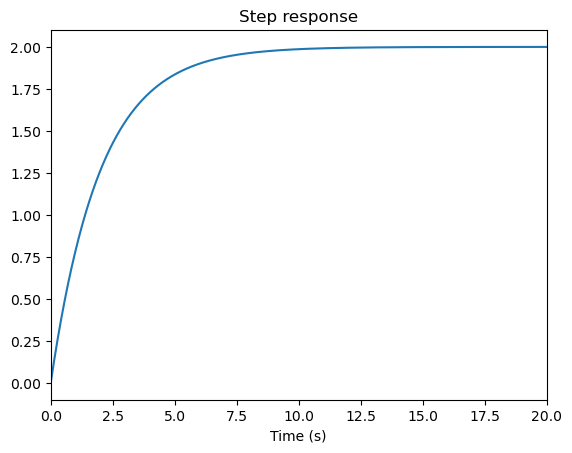

In [3]:
num = np.array([1])
den = np.array([m, k])
den_step = np.array([m, k, 0])

N = 1000
omega = eu.enel441_get_reasonable_freq_range(num,den,N)
G_jw = eu.enel441_fourier_transform(num,den,omega)
eu.enel441_bode(G_jw,omega)


t = np.linspace(0,20,N)
eu.enel441_step_response(num, den_step, t)

plt.show()

# Back to: Advantages of Control

- Ability to follow desired signals (responsiveness of system)
- Stability (design)
- Reduction of effects of process noise / load disturbances (noise rejection, compensation)
- Reduction of effects of model uncertainties
- Efficiency (design)

# Advantage 1 - Increase Responsiveness of System!

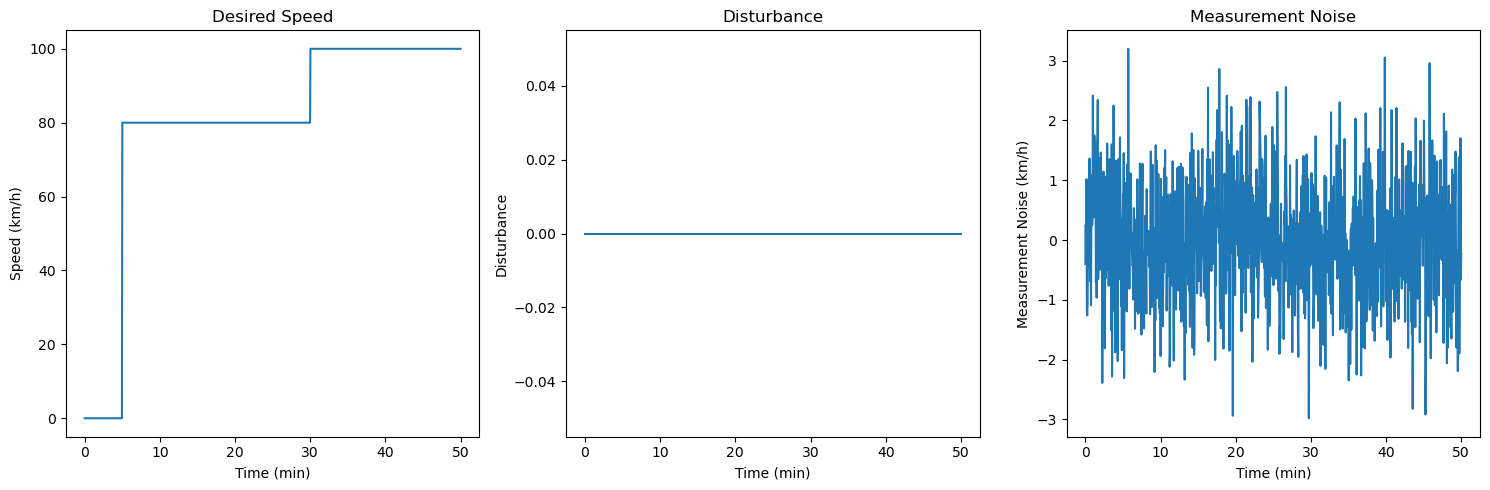

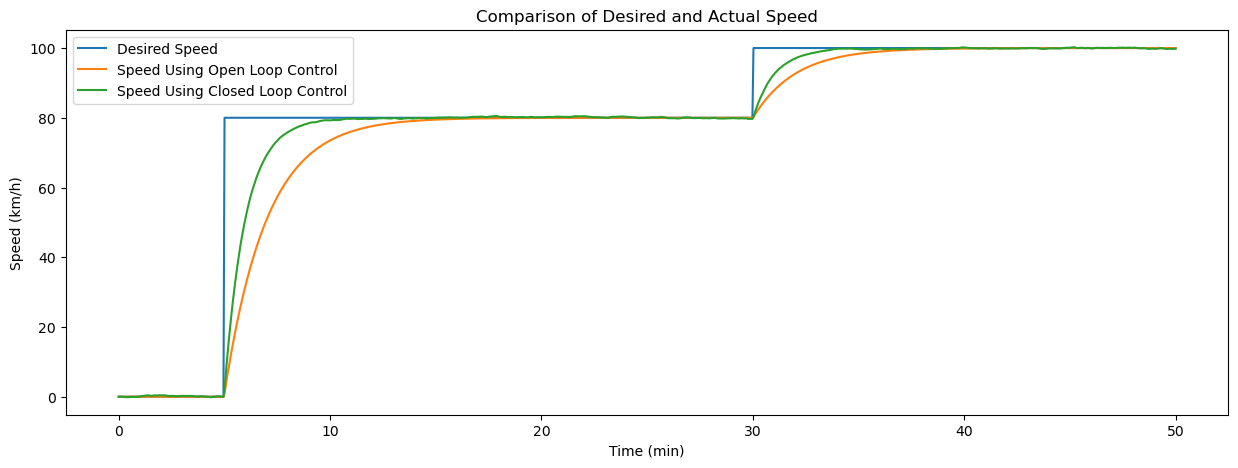

In [4]:
def sim_closed_loop(P,K,t,r,d,n):
    L = K*P
    S = 1/(1+L)
    T = L/(1+L)   

    y_r = ct.forced_response(T,t,r) 
    y_n = ct.forced_response(T,t,n) 
    y_d = ct.forced_response(P*S,t,d) 

    y = y_r.y + y_d.y + y_n.y

    u_r = ct.forced_response(K*S,t,r) 
    u_d = ct.forced_response(S,t,d) 
    u_n = ct.forced_response(K*S,t,d) 

    u = u_r.y + u_d.y - u_n.y

    return np.squeeze(y), np.squeeze(u)


def sim_open_loop(P,t,u,d):    
    y_r = ct.forced_response(P,t,u) 
    y_d = ct.forced_response(P,t,d) 
    y = np.squeeze(y_r.y) + np.squeeze(y_d.y)  
    return y


def make_open_and_closed_loop_plots(t,r,d,n,y2,y1):
    fig,ax = plt.subplots(1,3, figsize=(15,5) )
    ax[0].plot(t,r)
    ax[0].set_xlabel('Time (min)')
    ax[0].set_ylabel('Speed (km/h)')
    ax[0].set_title('Desired Speed')
    ax[1].plot(t,d)
    ax[1].set_xlabel('Time (min)')
    ax[1].set_ylabel('Disturbance')
    ax[1].set_title('Disturbance')   
    ax[2].plot(t,n)    
    ax[2].set_xlabel('Time (min)')
    ax[2].set_ylabel('Measurement Noise (km/h)')
    ax[2].set_title('Measurement Noise')
        
    fig.tight_layout()
    
    fig,ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(t,r, label='Desired Speed')
    ax.plot(t,y1, label='Speed Using Open Loop Control')   
    ax.plot(t,y2, label='Speed Using Closed Loop Control') 
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Speed (km/h)')
    ax.set_title('Comparison of Desired and Actual Speed')
    plt.legend()


# Reference, disturbance and measurement noise signals
t = np.linspace(0, 50, N)
r = [0 if ti <= 5 else
     80 if ti <= 30 else
     100 for ti in t]
r = np.array(r) 
d = np.zeros(N)
n = np.random.randn(N)

# simulate closed-loop and open-loop models for selected reference, disturbance and measurement noise signals
y_closed_loop, _ = sim_closed_loop(Car,K,t,r,d,n)
y_open_loop = sim_open_loop(Car,t,r*k,d)  # need to multiply input by k to "calibrate" input force. Why? (Check v(\infty) when r is a unit step).

# plot results
make_open_and_closed_loop_plots(t,r,d,n,y_closed_loop,y_open_loop)

# What is happening here? How are we able to speed up the response?

In open loop control we have pre-calculated what the input should be to achieve our desired speed. In this example it is just the desired speed.

So how is the controller able to speed up the response? Can think about it in (at least) two ways:

1. From the point of view of the input to the car: 
    - The controller is actively manipulating the input. 
    - This is an intuitive way to think about it, especially in the case of controlling the speed of a car. Instead of just setting the gas pedal (i.e. the force) to the level required to go the desired speed and keeping it there until you reach your desired speed, initially you might press harder on the gas to accelerate faster and then when you approach the desired speed, you reduce the pressure on the gas pedal. 
2. From the point of view of the poles of the system:
    - In open loop the transfer function from input (force of engine) to output is just the dynamics of the car.
    - In closed loop the transfer function from input to output has been changed, we have inserted a feedback loop and a controller.
    - The closed-loop transfer function will have different poles than the open-loop transfer function. The poles of the closed-loop system must be such that the step-response rise-time is less.

# Let's look at both points of view.


# In Class Activity!

For the above simulation, let's compare the input of our open-loop controller and the closed-loop controller. 
First we need to find the expression for the input to the plant. In the closed-loop system shown below, obtain an expression for the transfer function from $r(t)$ to $u(t)$

![feedbackloop](feedbackloop.png "Feedback")

For this exercise, assume that $n$ and $d$ are zero.


The transfer function from $r$ to $u$ is:
$$
\begin{align*}
\frac{U(s)}{R(s)} = \frac{K(s)}{1 + K(s)P(s)}
\end{align*}
$$


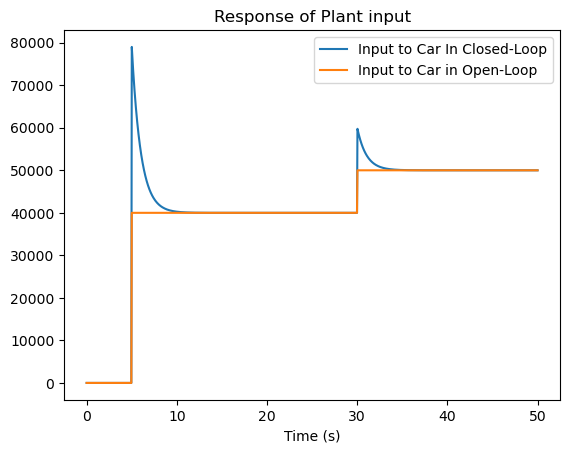

In [5]:
# Some Python code to plot the time response of $u$ given $r$. 

def plot_input_to_plant(K,P,r,t):
     X = K/(1+K*P)
     
     u_r = ct.forced_response(X,t,r) 

     fig, ax = plt.subplots(1)
     ax.plot(t, np.squeeze(u_r.y),label='Input to Car In Closed-Loop')
     ax.set_title('Response of Plant input')
     ax.set_xlabel('Time (s)')
     
     return fig, ax

fig,ax = plot_input_to_plant(K,Car,r,t) 
ax.plot(t,r*k, label='Input to Car in Open-Loop')
ax.legend()

What is the main difference? How is the controller able to achieve the increase in response time of the car?

Point of view #2: look at poles of open- and closed-loop systems.

In a closed loop setup, what is the transfer function from desired speed (reference signal) to output?

# In Class Activity!

Find the transfer function from $r$ to $y$ for a closed loop system. Again, assume that $n$ and $d$ are zero. Note the transfer functions for the car and controller are:
$$
\begin{align*}
P(s) &= \frac{1}{ms + k} \\
K(s) &= \frac{ms + k}{s}
\end{align*}
$$
Determine which system has a faster rise time.

The transfer function from $r$ to $y$ is:
$$
\begin{align*}
\frac{Y(s)}{R(s)} &= \frac{K(s)P(s)}{1 + K(s)P(s)} \\
&= \frac{1}{s+1}
\end{align*}
$$

The rise time for a first order system $\frac{a}{s+a}$ is $T_r = 2.2/a$. The bigger, $a$, the faster the rise time. 

In conclusion, 
- The open-loop transfer function has a pole at $-k/m = -500/1000 = -0.5$. $T_r = 2.2/0.5 = 4.4$.
- The closed-loop system has a pole at $-1$. $T_r = 2.2/1 = 2.2$.
- The closed-loop system has faster rise time. 



So far we have seen that the controller sped up the dynamics of the system. 

Let's continue to illustrate the other advantages of using controllers.

# Advantage 2 - Disturbance Rejection

# Effect of disturbance (open-loop vs closed-loop)

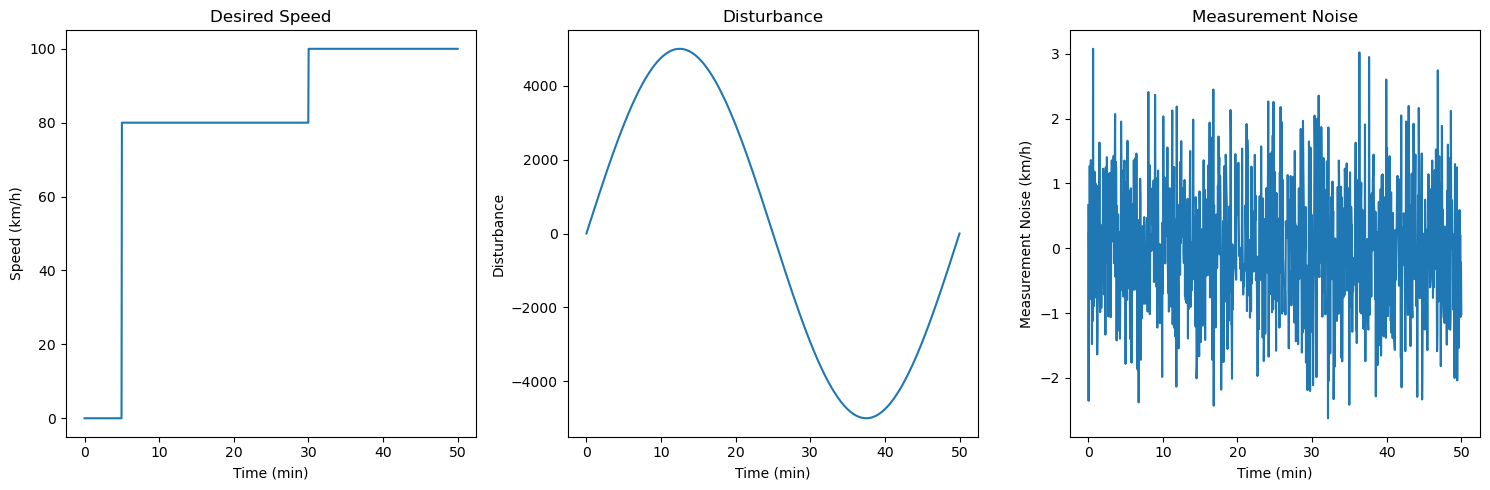

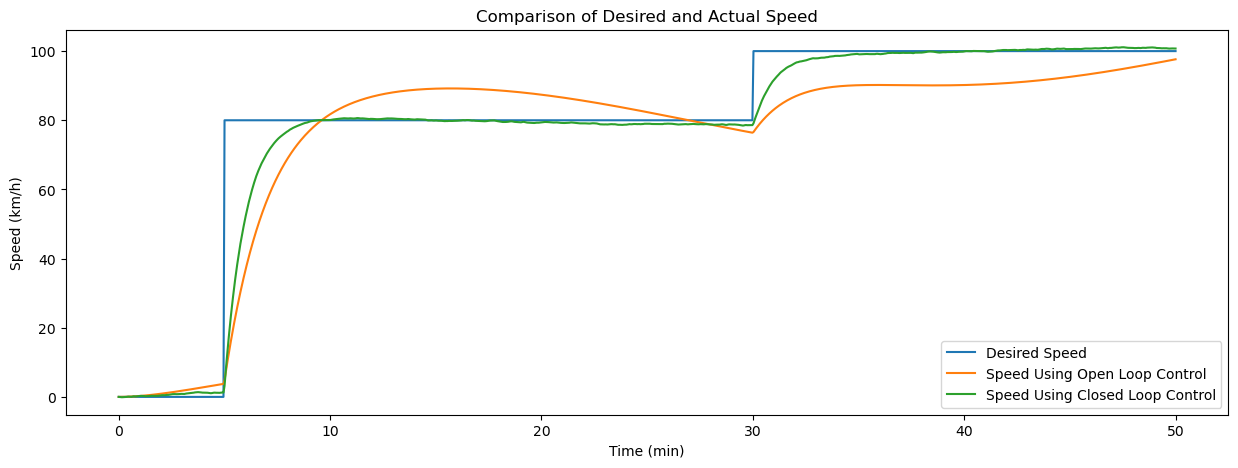

In [8]:
t = np.linspace(0, 50, N)
r = [0 if ti <= 5 else
     80 if ti <= 30 else
     100 for ti in t]
r = np.array(r) 
n = np.random.randn(N)

d_hill = 10*np.sin(t/100*np.pi*4)*k
y_closed_loop, u_closed_loop = eu.enel441_sim_closed_loop(Car,K,t,r,d_hill,n)
y_open_loop = eu.enel441_sim_open_loop(Car,t,r*k,d_hill)

eu.enel441_make_open_and_closed_loop_plots(t,r,d_hill,n,y_closed_loop,y_open_loop)


# Again - What is happening here? 

How is the controller able to maintain the correct speed, even when going up hill and down hill?

Again - Let's look at what the controller is prescribing as the input to the car.

# In Class Activity!

Derive the expression for the input to the plant based on the feedback diagram below. This time express the input in terms of $r$ and $d$. Assume that $n$ is zero. 

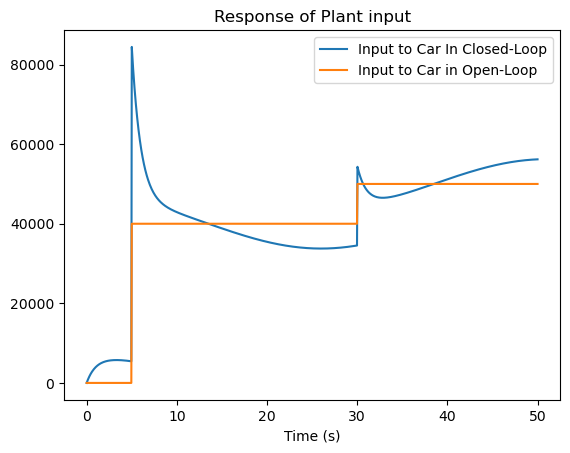

In [9]:
def plot_input_to_plant(K,P,r,d,t):
    # Add code here
    L = K*P
    S = 1/(1+L)
    T = L/(1+L)   

    X_r = K*S
    X_d = S
    
    u_r = ct.forced_response(X_r,t,r) 
    u_d = ct.forced_response(X_d,t,d) 

    u = u_r.y + u_d.y

    fig, ax = plt.subplots(1)
    ax.plot(t, np.squeeze(u),label='Input to Car In Closed-Loop')
    ax.set_title('Response of Plant input')
    ax.set_xlabel('Time (s)')
     
    return fig, ax

d_hill = 100*np.sin(t/100*np.pi*4)*k
fig,ax = plot_input_to_plant(K,Car,r,d_hill,t)
ax.plot(t,r*k, label='Input to Car in Open-Loop')
ax.legend()

# Advantage 3 - Reducing the effects of model uncertainty

Suppose that the dynamics of the car change, or are not exactly represented by the model. 

# Effect of uncertainty in the model (open-loop vs closed-loop)

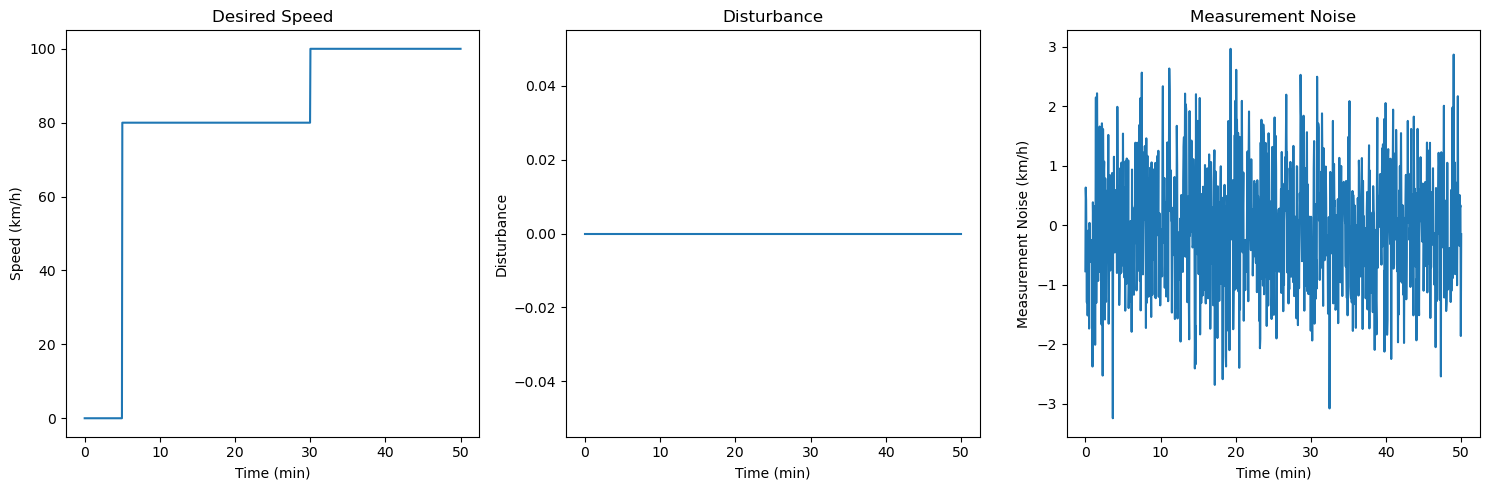

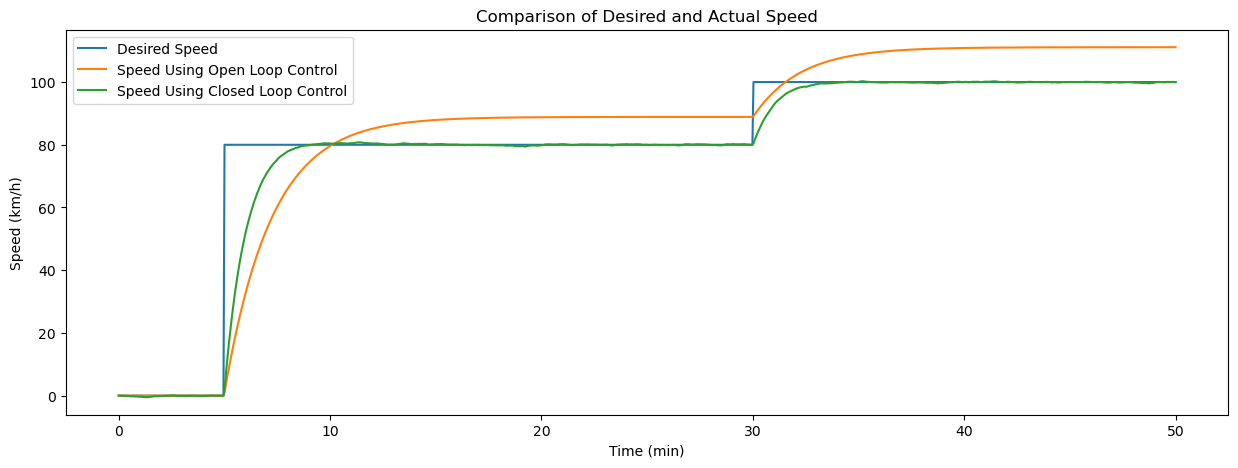

In [10]:
k = 500
k_new = 450

Car_changed = 1/(m*s+k_new)


t = np.linspace(0, 50, N)
r = [0 if ti <= 5 else
     80 if ti <= 30 else
     100 for ti in t]
r = np.array(r) 
d = np.zeros(N)
n = np.random.randn(N)


y_closed_loop, u_closed_loop = eu.enel441_sim_closed_loop(Car_changed,K,t,r,d,n)
y_open_loop = eu.enel441_sim_open_loop(Car_changed,t,r*k,d)
    
eu.enel441_make_open_and_closed_loop_plots(t,r,d,n,y_closed_loop,y_open_loop)

# Summary so far

Feedback can help with:
- Increasing responsiveness of system
- Reduction of effects of process noise / load disturbances (noise rejection, compensation)
- Reduction of effects of model uncertainties